In [38]:
import pandas as pd
import geopandas as gpd
import seaborn as sns
from scipy import stats
from matplotlib import pyplot as plt
import matplotlib.colors as colors
import matplotlib.patheffects as pe
import matplotlib as mpl
import numpy as np
import scipy as sp


In [3]:
from matplotlib import rcParams


In [244]:
# sns.set_style('white')
sns.set_style('darkgrid')
sns.set_context("paper", font_scale = 1)

plt.rc('font', family='serif')

plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')
plt.rc('legend', title_fontsize='small', fontsize='small')


plt.rcParams['svg.fonttype'] = 'none'

In [5]:
from palettable import wesanderson
color_palette = wesanderson.Zissou_5.mpl_colors

In [6]:
# dataset = pd.read_pickle('../../geodata/results/01_master_building_dataset.pkl')
dataset = pd.read_pickle('../../../geodata/results/01_master_building_dataset.pkl')


In [7]:
maxvsh_cols    = dataset.columns[dataset.columns.str.contains('maxvsh')].tolist()
vaccess_cols   = dataset.columns[dataset.columns.str.contains('vwa')].tolist()
# mean_cols      = dataset.columns[dataset.columns.str.contains('mn')].tolist()
dist_cols      = dataset.columns[dataset.columns.str.contains('sum_')].tolist()
vconfig_cols   = np.setdiff1d(dataset.columns[np.where(dataset.columns == 'snt_0')[0][0]:np.where(dataset.columns == 'cmpx_gini')[0][0]+1].tolist(),dist_cols).tolist()
id_cols        = ['ID_Geb','Stockwerk','FassPktX','FassPktY','FassPktZ']

dataset['unit_pano'] = dataset['unit_pano'].fillna(0)



In [8]:
import joblib
xgb_model   = joblib.load("../../../geodata/results/t10agglo_models/tr292ts73_XGB.joblib")
model_feats    = maxvsh_cols+vaccess_cols+vconfig_cols+dist_cols

import joblib
scaler_4model   = joblib.load("../../../geodata/results/scaler_for_model.joblib")

X = dataset.copy()
X[model_feats] = scaler_4model.transform(dataset[model_feats])

X['XGB'] = xgb_model.predict(X[xgb_model.feature_names_in_])


[20:27:42] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:553: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.



/Users/adamswietek/opt/anaconda3/envs/env_intel_sdb/lib/python3.10/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator MinMaxScaler from version 1.2.1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [9]:
sel_10agglo_lst = dataset.groupby(['Agglo_Name','Rich_Nabr'])['GMDNR'].size().unstack().sort_values(by = 'R', ascending = False).head(10).index.tolist()
dat = X.query("Agglo_Name in @sel_10agglo_lst")#.query('net_income_ptp < 250')
dat = dat.query("Agglo_Name in @sel_10agglo_lst")#.query('net_income_ptp < 250')


In [10]:
dat['error'] = np.log(dat['net_income_ptp']/dat['XGB'])

In [11]:
df = dat[['Agglo_Name','net_income_ptp','error']].melt(id_vars = ['Agglo_Name','net_income_ptp'])
df = dat[['Agglo_Name','error','XGB','net_income_ptp']].dropna().groupby('net_income_ptp').sample(10)

In [12]:
dfcomm = dat.reset_index().groupby(['Agglo_Name','GMDNAME'])['XGB'].describe()
dfcomm['net_income_ptp'] = dat.reset_index().groupby(['Agglo_Name','GMDNAME'])['net_income_ptp'].mean()
dfcomm['95%'] = dat.reset_index().groupby(['Agglo_Name','GMDNAME'])['XGB'].apply(lambda x: x.quantile(.95))



In [13]:
dfm = dat.reset_index().groupby('GMDNAME')['net_income_ptp','error','XGB'].mean()
dfm['err_min'] = dat.reset_index().groupby('GMDNAME')['error'].min()
dfm['err_max'] = dat.reset_index().groupby('GMDNAME')['error'].max()
dfm['err_var'] = dat.reset_index().groupby('GMDNAME')['error'].var()
dfm['err_med'] = dat.reset_index().groupby('GMDNAME')['error'].median()
dfm['err_skew'] = dat.reset_index().groupby('GMDNAME')['error'].skew()


/var/folders/7b/rl6lkdns1dbfv_n3wwwmq8580000gn/T/ipykernel_62794/1268852788.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  dfm = dat.reset_index().groupby('GMDNAME')['net_income_ptp','error','XGB'].mean()


In [14]:
from palettable import wesanderson

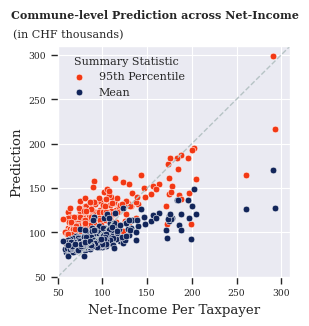

In [247]:
f, ax = plt.subplots(figsize = (3,3))

sns.scatterplot(data = dfcomm, ax = ax, 
            x = 'net_income_ptp', y = '95%',
            color = color_palette[2],#wesanderson.Zissou_5.mpl_colors[2], 
            edgecolor="white",
            # alpha = .75,
            label = '95th Percentile')
sns.scatterplot(data = dfcomm, ax = ax, 
            x = 'net_income_ptp', y = 'mean',
            color = color_palette[1],#wesanderson.Zissou_5.mpl_colors[1],
            edgecolor="white", 
            # alpha = .75,
            label = 'Mean')

sns.move_legend(ax, "upper left", frameon = False, title = 'Summary Statistic', fontsize = 'small')

ax.set_xlabel("Net-Income Per Taxpayer", fontsize = 'medium')
ax.set_ylabel('Prediction', fontsize = 'medium')

# ax.yaxis.grid(color='lightgrey', linestyle='dashed', lw = .5)
# ax.xaxis.grid(color='lightgrey', linestyle='dashed', lw = .5)

# sns.despine(left=False,top=True,right = True, bottom=False)
# ax.spines[['left','bottom']].set_linewidth(1.1)

ax.set_title('Commune-level Prediction across Net-Income',loc = 'left', x = -.2,wrap = True, fontsize = 'small', fontweight = 'bold', pad = 20)
ax.text(s = '(in CHF thousands)', x= 0,y =320,fontsize = 'small')

ax.tick_params(axis = 'both', which = 'major', bottom=True, left = True)

ax.axline((50,50), slope = 1, color = color_palette[4], ls = 'dashed', lw = 1)
ax.set_ylim(50,310)
ax.set_xlim(50,310)

plt.savefig('../../../LUP_VisualCapital/figs/fig2_ch_commune_aggregated.pdf',bbox_inches = 'tight')


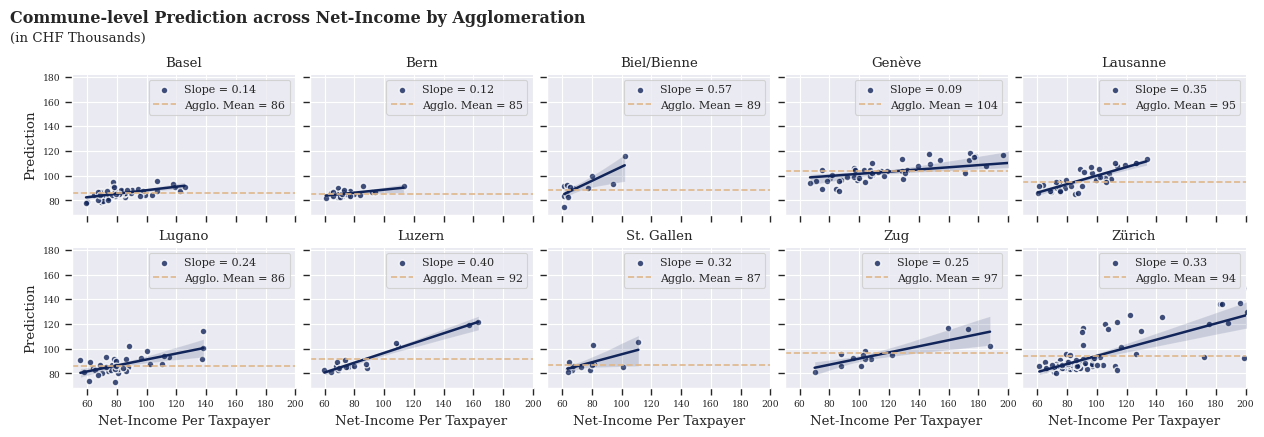

In [254]:
g = sns.lmplot(data = dfcomm.reset_index().dropna(), col='Agglo_Name', col_wrap=5, height = 2, aspect = 1.25,
            x = 'net_income_ptp', y = 'mean', 
            scatter_kws = {'edgecolor': 'white','facecolor':color_palette[1]},
            line_kws={'color':color_palette[1]})
for ax, feature in zip(g.axes.flat, g.col_names):
    df = dfcomm.reset_index().dropna().query('Agglo_Name == @feature')
    mn = dat.query('Agglo_Name == @feature')['XGB'].mean()
    slope, intercept, r_value, p_value, std_err = sp.stats.linregress(x=df['net_income_ptp'], y = df['mean'])

    # r, pvalue = scipy.stats.pearsonr(df['net_income_ptp'], df['mean'])
    ax.axhline(mn, ls='--', c= color_palette[3], label = f'Agglo. Mean = {mn:.0f}')
    ax.collections[0].set_label(f'Slope = {slope:.2f}')
    
    # ax.text(s = f'Mean = {mn:.2f}', x = 100,y = 150, color = color_palette[3])

    ax.legend(loc = 0)
# annotate
g.set_titles("{col_name}")
g.set(xlim=(50, 200))
g.set_axis_labels(y_var = 'Prediction', x_var = 'Net-Income Per Taxpayer')
g.tick_params(axis = 'both', bottom = True, left = True)
g.fig.suptitle('Commune-level Prediction across Net-Income by Agglomeration', fontsize = 'large',x = 0, y = 1.08,fontweight = 'bold', ha = 'left')
g.fig.text(x=0, y=1.0, s="(in CHF Thousands)")
# _ = g.map_dataframe(annotate)

# plt.tight_layout()
plt.savefig('../../../LUP_VisualCapital/figs/fig3_agglo_pred_v_income.pdf',bbox_inches = 'tight')


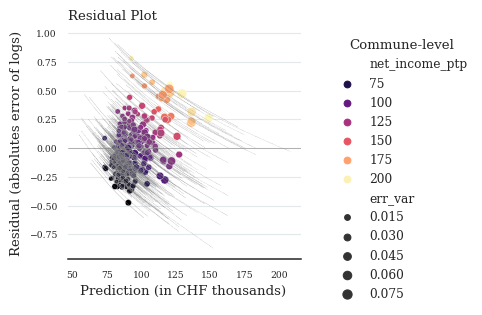

In [12]:
f, ax = plt.subplots(figsize=(3, 3))

sns.scatterplot(ax = ax, data = dfm , 
                x = 'XGB', y = 'err_med', size = 'err_var', hue = 'net_income_ptp', palette = 'magma', legend = True)
sns.lineplot(ax = ax, data = df, 
             x = 'XGB', y = 'error', style = 'net_income_ptp', color = 'grey', linewidth = 0.25, alpha = .75, legend = False)

sns.despine()
ax.set_xlabel("Prediction (in CHF thousands) ")
ax.set_ylabel('Residual (absolutes error of logs)')
ax.axhline(0, color = 'grey', linewidth = 0.5, alpha = .75)
ax.set_title('Residual Plot',loc = 'left', wrap = True)#,fontweight = 'bold', pad = 0)
ax.spines[['top','right','left']].set_visible(False)
ax.spines[['bottom','left']].set_linewidth(1.1)
ax.grid(which="major", axis='y', color='#758D99', alpha=0.2, zorder=1)
# ax.grid(which="major", axis='y', color='#758D99', alpha=0.2, zorder=5)

ax.legend(bbox_to_anchor=(1.1,1), title = "Commune-level", frameon = False)

In [22]:
z_lst = dat.query('Agglo_Name == "Zürich"').GMDNAME.value_counts()#.head(5).index.tolist()

In [23]:
z_lst = ["Zürich" ,"Zollikon", "Küsnacht (ZH)"  ,"Zumikon", "Erlenbach (ZH)" , 
         "Adliswil", "Kilchberg (ZH)","Rüschlikon","Langnau am Albis","Thalwil",'Oberrieden']      

In [24]:
#IMPORT ADMINISTRATION BOUNDARIES
ch_g2g18  = gpd.read_file('../../../geodata/ch_districts/ch_districts_g2g18.gpkg')
# ch_lakes = gpd.read_file('../../../geodata/ch_lakes/ch_lakes.gpkg')

In [25]:
ch_agglo = gpd.read_file('../../../geodata/ch_agglo/swiss_urban_agglomerations.gpkg')

In [310]:
zlake = gpd.clip(ch_lakes.query('ID0 == "9050"').dissolve(), ch_g2g18.query('GMDNAME in @z_lst').dissolve().total_bounds)


In [107]:
ch = ch_g2g18.dissolve()
agglo_poly = ch_agglo.query("Agglo_Name in @dat.Agglo_Name.unique()").dissolve('Agglo_Name')
agglo_poly = gpd.clip(agglo_poly, ch)
Xsamp = X.sample(1000000)
Xsamp['XGB_scaled'] =  (Xsamp.XGB - Xsamp.XGB.min())/(Xsamp.XGB.max() - Xsamp.XGB.min())
dat['XGB_scaled'] =  (dat.XGB - dat.XGB.min())/(dat.XGB.max() - dat.XGB.min())


KeyboardInterrupt: 

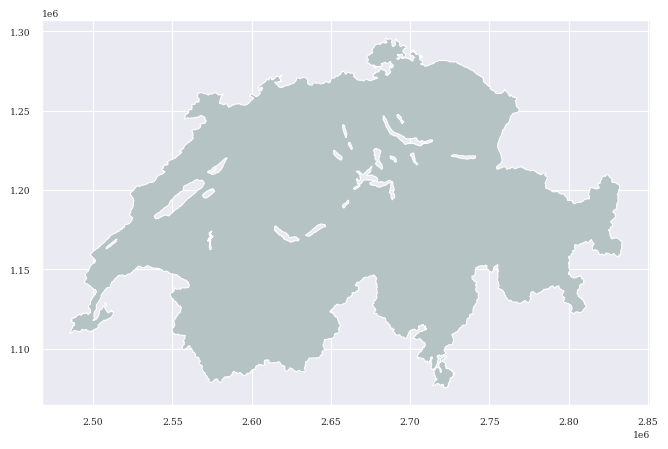

In [78]:
f, ax = plt.subplots(figsize =(10,5))

ch.plot(color = color_palette[4], ax = ax)
Xsamp.plot('XGB_scaled',  markersize = .01, ax=ax,  
            legend = True,scheme = 'naturalbreaks',
            cmap="PuBuGn",
            legend_kwds={"loc": "center left", "bbox_to_anchor": (1, 0.5)},
                                    # legend_kwds={"label": "(in CHF thousands)",'shrink':.5}
                                    )
agglo_poly.plot(ax = ax, facecolor = 'none', edgecolor = color_palette[1], lw = .5)
agglo_poly.reset_index().apply(lambda x: ax.annotate(text=x['Agglo_Name'],
                    color = 'k',#color_palette[1],
                    xy=(x.geometry.centroid.coords[0][0]-9500,x.geometry.centroid.coords[0][1]+6500), 
                    ha='right',#path_effects=[pe.withStroke(linewidth=1, foreground='k')]
                    ),axis=1)
leg1 = ax.get_legend()
leg1.set_title("Visual Capital Percentiles")
# ax.set_title('')
plt.axis('off')

plt.savefig('../../../LUP_VisualCapital/figs/fig4_ch_predicions.pdf',bbox_inches = 'tight',rasterized=True)


In [100]:
z_lst = ["Zürich" ,"Zollikon", "Küsnacht (ZH)"  ,"Zumikon", "Erlenbach (ZH)" , 
         "Adliswil", "Kilchberg (ZH)","Rüschlikon","Langnau am Albis","Thalwil",'Oberrieden'] 

In [126]:
import PIL
import numpy as np
import urllib

In [157]:
ch_names = gpd.read_file('../../../geodata/ch_districts/shp_LV95_LN02/swissNAMES3D_LIN.shp')

In [283]:
comms = ["Saint-Sulpice (VD)","Préverenges","Morges"]
ch_g2g18.query('GMDNAME in @comms').dissolve().total_bounds

array([2526162., 1150445., 2534613., 1152945.])

In [299]:
#BASEL
xmin, ymin= 2608780,1264256
xmax, ymax= 2619426,1272464

#ZURICH
xmin, ymin= 2682015,1238484
xmax, ymax= 2688492,1244428

xmin, ymin= 2680459,1246557
xmax, ymax= 2686305,1248871


#LAUSANNE
comms = ["Saint-Sulpice (VD)","Préverenges","Morges"]
xmin, ymin, xmax, ymax = ch_g2g18.query('GMDNAME in @comms').dissolve().total_bounds

dat_ = X.cx[xmin:xmax, ymin:ymax]
dat_.shape

(6115, 85)

/Users/adamswietek/opt/anaconda3/envs/env_intel_sdb/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


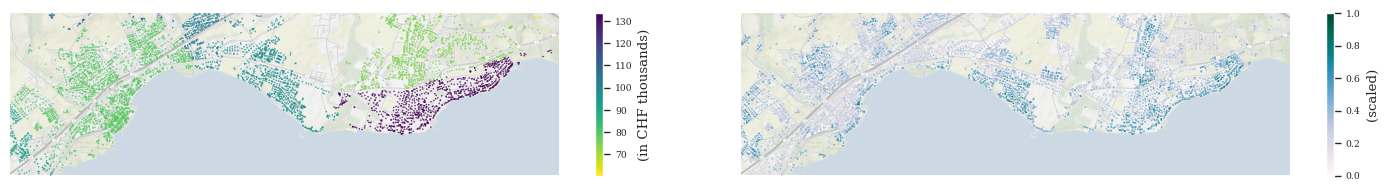

In [300]:
import contextily as cx
fig = plt.figure()
fig.set_figheight(2)
fig.set_figwidth(15)

ax2 = plt.subplot2grid(shape=(1, 2), loc=(0, 0), colspan=1)
ax3 = plt.subplot2grid(shape=(1, 2), loc=(0, 1), colspan=1)

ax2.set_xlim(xmin,xmax),ax2.set_ylim(ymin,ymax)
ax3.set_xlim(xmin,xmax),ax3.set_ylim(ymin,ymax)

ax2.axis('off'),ax3.axis('off')

dat_['XGB_scaled'] =  (dat_.XGB - dat_.XGB.min())/(dat_.XGB.max() - dat_.XGB.min())

dat_.plot('net_income_ptp', markersize = .1, ax=ax2, cmap = 'viridis_r', legend = True,
                                    legend_kwds={"label": "(in CHF thousands)","location":"right",})



dat_.plot('XGB_scaled', markersize = .1, ax=ax3, cmap = 'PuBuGn', legend = True,
                                    legend_kwds={"label": "(scaled)","location":"right",})

# ax2.set_xlim(xmin,xmax),ax2.set_ylim(ymin,ymax)
cx.add_basemap(ax2, crs=dat.crs.to_string(), source=cx.providers.Stamen.Terrain, alpha = .5, zoom = 15,attribution = "")
cx.add_basemap(ax3, crs=dat.crs.to_string(), source=cx.providers.Stamen.Terrain, alpha = .5, zoom = 15,attribution = "")

plt.tight_layout()
# Display the plot
plt.show()

/Users/adamswietek/opt/anaconda3/envs/env_intel_sdb/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


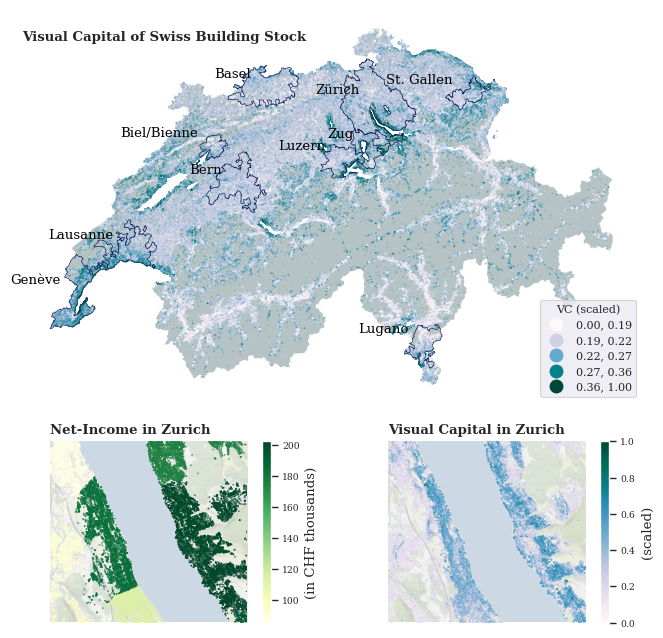

In [302]:
#Switzerland
Xsamp = X.sample(1000000)
Xsamp['XGB_scaled'] =  (Xsamp.XGB - Xsamp.XGB.min())/(Xsamp.XGB.max() - Xsamp.XGB.min())

#ZURICH
xmin, ymin= 2682015,1238484
xmax, ymax= 2688492,1244428
dat_ = X.cx[xmin:xmax, ymin:ymax]
dat_['XGB_scaled'] =  (dat_.XGB - dat_.XGB.min())/(dat_.XGB.max() - dat_.XGB.min())


# creating grid for subplots
fig = plt.figure()
fig.set_figheight(8)
fig.set_figwidth(8)

ax1 = plt.subplot2grid(shape=(3, 2), loc=(0, 0), colspan=2, rowspan=2)
ax2 = plt.subplot2grid(shape=(3, 2), loc=(2, 0), colspan=1)
ax3 = plt.subplot2grid(shape=(3, 2), loc=(2, 1), colspan=1)

ax1.tick_params(axis='both', which='major', bottom=False, left=False, labelbottom=False, labelleft=False)
ax2.tick_params(axis='both', which='major', bottom=False, left=False, labelbottom=False, labelleft=False)
ax3.tick_params(axis='both', which='major', bottom=False, left=False, labelbottom=False, labelleft=False)

ax1.set_title('Visual Capital of Swiss Building Stock', x = 0, y = .9, ha = 'left', fontweight = 'bold')
ax2.set_title('Net-Income in Zurich', x = 0, y = 1, ha = 'left', fontweight = 'bold')
ax3.set_title('Visual Capital in Zurich', x = 0, y = 1, ha = 'left', fontweight = 'bold')

ax1.axis('off'),ax2.axis('off'),ax3.axis('off')
ax2.set_xlim(xmin,xmax),ax2.set_ylim(ymin,ymax)
ax3.set_xlim(xmin,xmax),ax3.set_ylim(ymin,ymax)

# ch_g2g18.query('GMDNAME in @z_lst').apply(lambda x: ax2.annotate(text=x['GMDNAME'], xy=x.geometry.centroid.coords[0], ha='center',), axis=1)
# ch_g2g18.query('GMDNAME in @z_lst').apply(lambda x: ax3.annotate(text=x['GMDNAME'], xy=x.geometry.centroid.coords[0], ha='center'), axis=1)


cx.add_basemap(ax2, crs=dat.crs.to_string(), source=cx.providers.Stamen.Terrain, alpha = .5, zoom = 15, attribution="")
cx.add_basemap(ax3, crs=dat.crs.to_string(), source=cx.providers.Stamen.Terrain, alpha = .5, zoom = 15, attribution="")


ch.plot(color = color_palette[4], ax = ax1)


Xsamp.plot('XGB_scaled',  markersize = .01, ax=ax1, 
            legend = True,scheme = 'naturalbreaks',
            cmap="PuBuGn",
            legend_kwds={"loc": "lower right"}#, "bbox_to_anchor": (1, 0.5)},
                                    # legend_kwds={"label": "(in CHF thousands)",'shrink':.5}
                                    )

agglo_poly.plot(ax = ax1, facecolor = 'none', edgecolor = color_palette[1], lw = .5)
agglo_poly.reset_index().apply(lambda x: ax1.annotate(text=x['Agglo_Name'],
                    color = 'k',#color_palette[1],
                    xy=(x.geometry.centroid.coords[0][0]-9500,x.geometry.centroid.coords[0][1]+6500), 
                    ha='right',#path_effects=[pe.withStroke(linewidth=1, foreground='k')]
                    ),axis=1)
leg1 = ax1.get_legend()
leg1.set_title("VC (scaled)")


# ch_g2g18.query('GMDNAME in @z_lst').plot(edgecolor = 'white', linewidth = 1, facecolor = color_palette[4],ax=ax2,zorder= 1)
# ch_g2g18.query('GMDNAME in @z_lst').dissolve().plot(facecolor = 'none', edgecolor = 'black', ax = ax2)
# # zlake.plot(color = 'lightblue', ax = ax)
dat_.plot('net_income_ptp', markersize = .1, ax=ax2, cmap = 'YlGn', legend = True,
                                    legend_kwds={"label": "(in CHF thousands)"})


# ch_g2g18.query('GMDNAME in @z_lst').plot(edgecolor = 'white', linewidth = 1, facecolor = color_palette[4],ax=ax3,zorder= 1)
# ch_g2g18.query('GMDNAME in @z_lst').dissolve().plot(facecolor = 'none', edgecolor = 'black', ax = ax2)
# # zlake.plot(color = 'lightblue', ax = ax)
dat_.plot('XGB_scaled', markersize = .1, ax=ax3, cmap = 'PuBuGn', legend = True,
                                    legend_kwds={"label": "(scaled)"})

plt.savefig('../../../LUP_VisualCapital/figs/fig4_ch_predictions.jpg',bbox_inches = 'tight',dpi=300)


(2675424.0, 2693068.0, 1237947.95, 1255109.05)

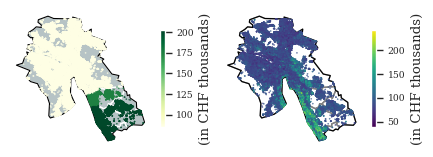

In [63]:
f, ax = plt.subplots(ncols = 2, figsize=(5, 5))

# axis 1_________

ch_g2g18.query('GMDNAME in @z_lst').plot(edgecolor = 'white', linewidth = 1, facecolor = color_palette[4],ax=ax[0],zorder= 1)
ch_g2g18.query('GMDNAME in @z_lst').dissolve().plot(facecolor = 'none', edgecolor = 'black', ax = ax[0])
# zlake.plot(color = 'lightblue', ax = ax)
dat.query('GMDNAME in @z_lst').plot('net_income_ptp', markersize = .1, ax=ax[0], cmap = 'YlGn', legend = True,
                                    legend_kwds={"label": "(in CHF thousands)", 'shrink':.25})

ax[0].axis('off')
# plt.axis('off')
# plt.title('Commune Avg. Net-Income Per Taxpayer (CLI)',loc = 'left', wrap = True)#,fontweight = 'bold', pad = 0)
# plt.axis('off')
ch_g2g18.query('GMDNAME in @z_lst').plot(edgecolor = 'grey', linewidth = 1, facecolor = 'none',ax=ax[1])
ch_g2g18.query('GMDNAME in @z_lst').dissolve().plot(facecolor = 'none', edgecolor = 'black', ax = ax[1])
# zlake.plot(color = 'lightblue', ax = ax)
dat.query('GMDNAME in @z_lst').plot('XGB', markersize = .1, ax=ax[1], cmap = 'viridis', legend = True,
                                    legend_kwds={"label": "(in CHF thousands)", 'shrink':.25})

# plt.title('Building-level Prediction (Visual Capital)',loc = 'left', wrap = True)#,fontweight = 'bold', pad = 0)
ax[1].axis('off')

(2675424.0, 2693068.0, 1234017.8, 1255296.2)

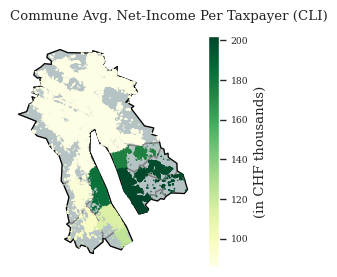

In [ ]:
f, ax = plt.subplots(ncols = 2, figsize=(3, 3))
ch_g2g18.query('GMDNAME in @z_lst').plot(edgecolor = 'white', linewidth = 1, facecolor = color_palette[4],ax=ax[0],zorder= 1)
ch_g2g18.query('GMDNAME in @z_lst').dissolve().plot(facecolor = 'none', edgecolor = 'black', ax = ax[0])
# zlake.plot(color = 'lightblue', ax = ax)
dat.query('GMDNAME in @z_lst').plot('net_income_ptp', markersize = .1, ax=ax[0], cmap = 'YlGn', legend = True,
                                    legend_kwds={"label": "(in CHF thousands)"})


plt.title('Commune Avg. Net-Income Per Taxpayer (CLI)',loc = 'left', wrap = True)#,fontweight = 'bold', pad = 0)
# plt.axis('off')

(2675424.0, 2693068.0, 1234017.8, 1255296.2)

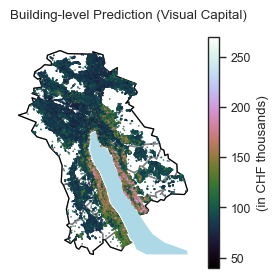

In [328]:
f, ax = plt.subplots(figsize=(3, 3))
ch_g2g18.query('GMDNAME in @z_lst').plot(edgecolor = 'grey', linewidth = 1, facecolor = 'none',ax=ax)
ch_g2g18.query('GMDNAME in @z_lst').dissolve().plot(facecolor = 'none', edgecolor = 'black', ax = ax)
zlake.plot(color = 'lightblue', ax = ax)
df.query('GMDNAME in @z_lst').plot('XGB', markersize = .1, ax=ax, cmap = 'cubehelix', legend = True,
                                    legend_kwds={"label": "(in CHF thousands)"})

plt.title('Building-level Prediction (Visual Capital)',loc = 'left', wrap = True)#,fontweight = 'bold', pad = 0)
plt.axis('off')

In [314]:
dat['abs_error'] = np.abs(dat['error'])

(2675424.0, 2693068.0, 1234017.8, 1255296.2)

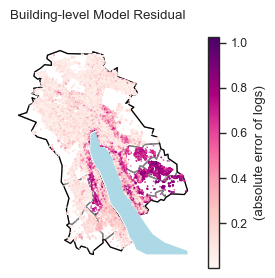

In [335]:
f, ax = plt.subplots(figsize=(3, 3))
ch_g2g18.query('GMDNAME in @z_lst').plot(edgecolor = 'grey', linewidth = 1, facecolor = 'none',ax=ax)
ch_g2g18.query('GMDNAME in @z_lst').dissolve().plot(facecolor = 'none', edgecolor = 'black', ax = ax)
zlake.plot(color = 'lightblue', ax = ax)
dat.query('GMDNAME in @z_lst').plot('abs_error', markersize = .1, ax=ax, cmap = 'RdPu', legend = True,
                                    legend_kwds={"label": "(absolute error of logs)"})

plt.title('Building-level Model Residual',loc = 'left', wrap = True)#,fontweight = 'bold', pad = 0)
plt.axis('off')